In [1]:
import h5py
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import matplotlib.cm as cm
from scipy.signal import savgol_filter
from scipy import stats

batch1 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch1.pkl', 'rb'))
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

numBat1 = len(batch1.keys())

batch2 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch2.pkl','rb'))
# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]

del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

numBat2 = len(batch2.keys())

batch3 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch3.pkl','rb'))
# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c38']
del batch3['b3c39']

numBat3 = len(batch3.keys())
numBat = numBat1 + numBat2 + numBat3
bat_dict = {**batch1, **batch2, **batch3}

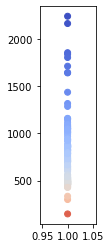

In [52]:
color=[]
cycle_=[]
plt.figure(figsize=(1,4))
for i,j in enumerate(bat_dict.keys()):
    sortcycle=bat_dict[j]['cycle_life']
    cycle_.append(sortcycle.tolist())
    c=(np.log10(sortcycle)-2)/(np.log10(2300)-2)
    color.append(c.tolist())

a=np.array(color).ravel()
b=np.array(cycle_).ravel()
chargecolor=cm.coolwarm_r(a)
plt.scatter(np.ones(len(a)),b,c=cm.coolwarm_r(a))

In [53]:
bat1_2 = {**batch1, **batch2}
prim_test_var=[]
prim_test_cycle=[]
Train_var=[]
Train_cycle=[]
for i,j in enumerate(bat1_2.keys()):
    if j=='b2c1':
        continue
    a=len(bat1_2.keys())
    Qdlin10,Qdlin100=bat_dict[j]['cycles']['9']['Qdlin'],bat_dict[j]['cycles']['99']['Qdlin']
    diff=diff=Qdlin100-Qdlin10
    var,cycle=np.var(diff),bat_dict[j]['cycle_life'].tolist()
    if i==83:
        prim_test_var.append(var)
        prim_test_cycle.append(cycle)
        break
    if i%2==0:
        prim_test_var.append(var)
        prim_test_cycle.append(cycle)
    if i%2==1:
        Train_var.append(var)
        Train_cycle.append(cycle)


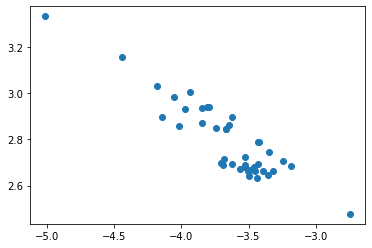

In [54]:
#train-> variance에 log 취해줘야함.
from sklearn.linear_model import ElasticNetCV
regr=ElasticNetCV(cv=4)
var=np.array(Train_var)
cycle=np.array(Train_cycle).ravel()
X_val=np.log10(np.abs(var))
Y_val=np.log10(cycle)
plt.scatter(X_val,Y_val)

data shape: (41, 1) (41,)
Elastic Net CV alpha: 0.0001078912075761506
Elastic Net CV coef: [-0.39529804]
Elastic Net CV intercept: 1.3480390387328947


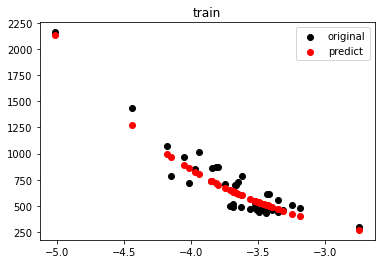

In [55]:
X=X_val.reshape(-1,1)
print('data shape:', X.shape, Y_val.shape)
regr.fit(X,Y_val)
print('Elastic Net CV alpha:',regr.alpha_)
print('Elastic Net CV coef:',regr.coef_)
print('Elastic Net CV intercept:',regr.intercept_)
y_pred1=regr.predict(X)
plt.scatter(X,10**Y_val,color='black',label='original')
plt.scatter(X,10**y_pred1,color='red',label='predict')
plt.title('train')
plt.legend()

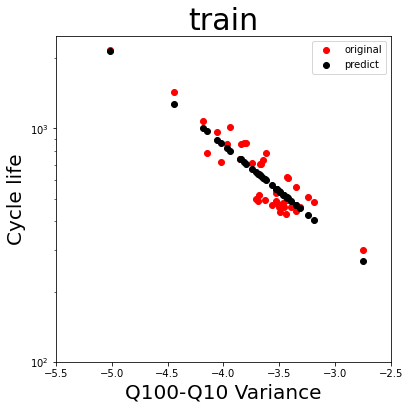

In [56]:
plt.figure(figsize=(6,6))
plt.scatter(X,10**Y_val,color='red',label='original')
plt.scatter(X,10**y_pred1,color='black',label='predict')
plt.title('train',size=30)
plt.yscale('log')
plt.ylim(100,2500)
plt.xlim(-5.5,-2.5)
plt.ylabel('Cycle life',size=20)
plt.xlabel('Q100-Q10 Variance',size=20)
plt.legend()

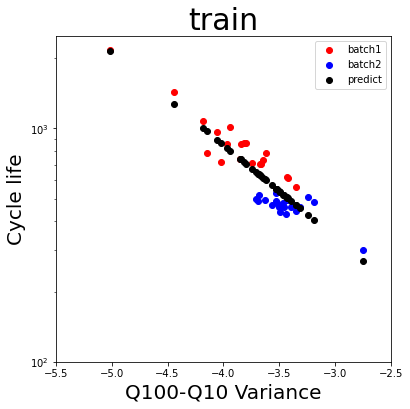

In [57]:
plt.figure(figsize=(6,6))
X1=X[:20];Y1=Y_val[:20]
X2=X[20:];Y2=Y_val[20:]
Yt1=y_pred1[:20]; Yt2=y_pred1[20:]

plt.scatter(X1,10**Y1,color='red',label='batch1')
plt.scatter(X2,10**Y2,color='blue',label='batch2')

plt.scatter(X,10**y_pred1,color='black',label='predict')

plt.title('train',size=30)
plt.yscale('log')
plt.ylim(100,2500)
plt.xlim(-5.5,-2.5)
plt.ylabel('Cycle life',size=20)
plt.xlabel('Q100-Q10 Variance',size=20)
plt.legend()

In [58]:
def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
from sklearn.metrics import mean_squared_error
rmse1=np.sqrt(mean_squared_error(10**Y_val,10**y_pred1))
print('train RMSE, Mean Absolute Percentage Error')
rmse1,MAPE(10**Y_val,10**y_pred1)

train RMSE, Mean Absolute Percentage Error


(103.64319387141127, 14.133951807729803)

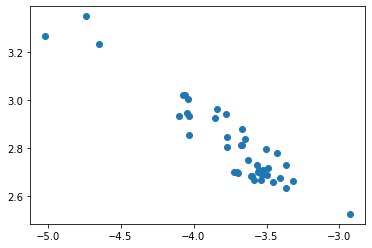

In [59]:
#primary 
p_var=np.array(prim_test_var)
p_cycle=np.array(prim_test_cycle).ravel()
p_X_val=np.log10(np.abs(p_var))
p_Y_val=np.log10(p_cycle)
plt.scatter(p_X_val,p_Y_val)

In [60]:
p_X.shape, p_Y_val.shape

((42, 1), (42,))

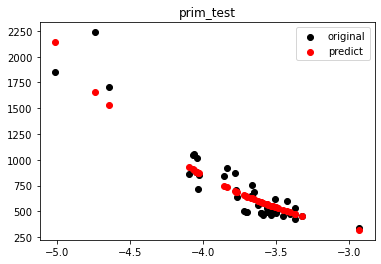

In [61]:
p_X=p_X_val.reshape(-1,1)
y_pred2=regr.predict(p_X)
plt.scatter(p_X_val,10**p_Y_val,color='black',label='original')
plt.scatter(p_X_val,10**y_pred2,color='red',label='predict')
plt.title('prim_test')
plt.legend()

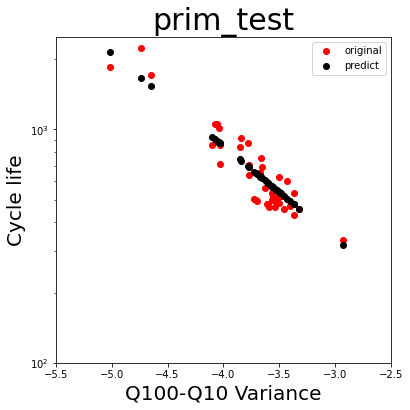

In [62]:
plt.figure(figsize=(6,6))
plt.scatter(p_X_val,10**p_Y_val,color='red',label='original')
plt.scatter(p_X_val,10**y_pred2,color='black',label='predict')
plt.title('prim_test',size=30)
plt.yscale('log')
plt.ylim(100,2500)
plt.xlim(-5.5,-2.5)
plt.ylabel('Cycle life',size=20)
plt.xlabel('Q100-Q10 Variance',size=20)
plt.legend()

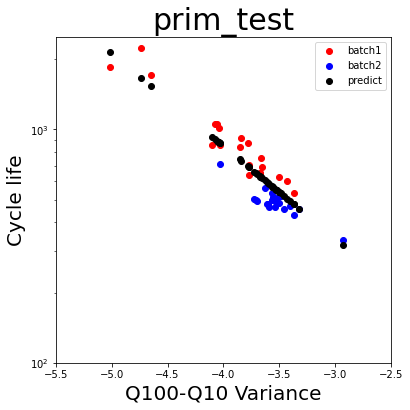

In [63]:
plt.figure(figsize=(6,6))
X_1=p_X_val[:21];Y_1=p_Y_val[:21]
X_2=p_X_val[21:];Y_2=p_Y_val[21:]
Yp1=y_pred2[:21]; Yp2=y_pred2[21:]

plt.scatter(X_1,10**Y_1,color='red',label='batch1')
plt.scatter(X_2,10**Y_2,color='blue',label='batch2')

plt.scatter(p_X_val,10**y_pred2,color='black',label='predict')

plt.title('prim_test',size=30)
plt.yscale('log')
plt.ylim(100,2500)
plt.xlim(-5.5,-2.5)
plt.ylabel('Cycle life',size=20)
plt.xlabel('Q100-Q10 Variance',size=20)
plt.legend()

In [64]:
from sklearn.metrics import mean_squared_error

rmse2=np.sqrt(mean_squared_error(10**p_Y_val,10**y_pred2))
print('prim_Test RMSE, Mean Absolute Percentage Error')
rmse2,MAPE(10**p_Y_val,10**y_pred2)

prim_Test RMSE, Mean Absolute Percentage Error


(138.4263915998672, 13.194929958516072)

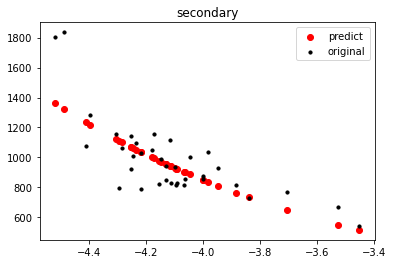

In [65]:
Cycle3=[]
VAR3=[]
for i,j in enumerate(batch3.keys()):
    if j=='b3c16':
        continue
    if j=='b3c17':
        continue
    if j=='b3c42':
        continue
    if j=='b3c43':
        continue
    Qdlin10,Qdlin100=bat_dict[j]['cycles']['9']['Qdlin'],bat_dict[j]['cycles']['99']['Qdlin']
    diff=Qdlin100-Qdlin10
    var,cycle=np.var(diff),bat_dict[j]['cycle_life'].tolist()
    VAR3.append(var)
    Cycle3.append(cycle)
x_val3=np.array(VAR3)
y_val3=np.array(Cycle3).ravel()
X_val3=np.log10(np.abs(x_val3))
Y_val3=np.log10(y_val3)
X3=X_val3.reshape(-1,1)

X3.shape, Y_val3.shape
y_pred3=regr.predict(X3)
plt.scatter(X3,10**y_pred3,color='r',label='predict')
plt.scatter(X_val3,10**Y_val3,color='black',s=10,label='original')
plt.title('secondary')
plt.legend()

In [66]:
X_val3.shape, Y_val3.shape

((36,), (36,))

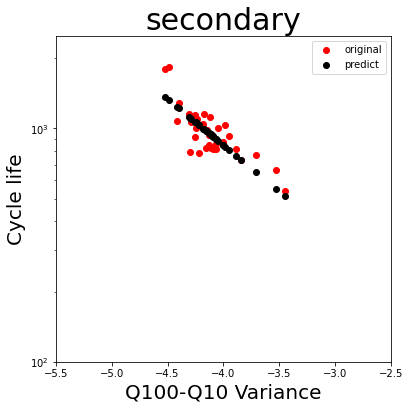

In [67]:
plt.figure(figsize=(6,6))
plt.scatter(X_val3,10**Y_val3,color='red',label='original')
plt.scatter(X3,10**y_pred3,color='black',label='predict')
plt.title('secondary',size=30)
plt.yscale('log')
plt.ylim(100,2500)
plt.xlim(-5.5,-2.5)
plt.ylabel('Cycle life',size=20)
plt.xlabel('Q100-Q10 Variance',size=20)
plt.legend()

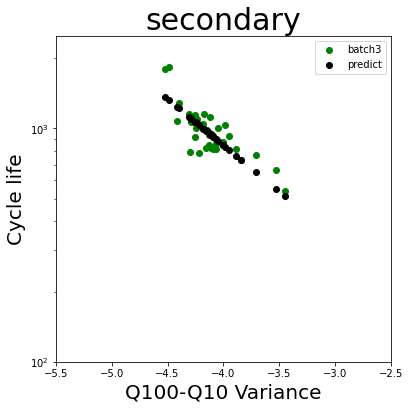

In [68]:
plt.figure(figsize=(6,6))
plt.scatter(X_val3,10**Y_val3,color='green',label='batch3')
plt.scatter(X3,10**y_pred3,color='black',label='predict')
plt.title('secondary',size=30)
plt.yscale('log')
plt.ylim(100,2500)
plt.xlim(-5.5,-2.5)
plt.ylabel('Cycle life',size=20)
plt.xlabel('Q100-Q10 Variance',size=20)
plt.legend()

(41,) (41,)
(42,) (42,)
(36,) (36,)
train_coeff: -0.897
prim_coeff: -0.919
sec_coeff: -0.733


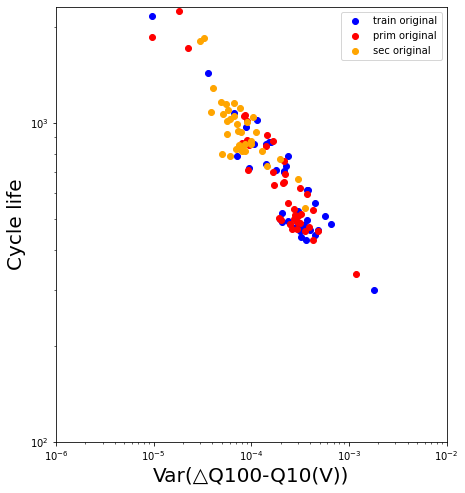

In [69]:
plt.figure(figsize=(7,8))
X1=np.array(X).ravel()
Y1=np.array(10**Y_val).ravel()
print(X1.shape,Y1.shape)
plt.scatter(10**X,Train_cycle,color='blue',label='train original')
r_train = np.corrcoef(X1,Y1)
r_t=np.round(r_train[0,1],3)


X2=np.array(p_X_val).ravel()
Y2=np.array(10**p_Y_val).ravel()
print(X2.shape,Y2.shape)
plt.scatter(10**p_X_val,prim_test_cycle,color='red',label='prim original')
r_prim = np.corrcoef(X2,Y2)
r_p=np.round(r_prim[0,1],3)


X3=np.array(X_val3).ravel()
Y3=np.array(10**Y_val3).ravel()
print(X3.shape,Y3.shape)
plt.scatter(10**X_val3,Cycle3,color='orange',label='sec original')
r_sec = np.corrcoef(X3,Y3)
r_s=np.round(r_sec[0,1],3)



print('train_coeff:', r_t)
print('prim_coeff:', r_p)
print('sec_coeff:', r_s)
                
plt.xscale('log')
plt.yscale('log')
plt.axis([10**(-6),10**(-2),100,2300])
plt.xlabel('Var(△Q100-Q10(V))',fontsize=20)
plt.ylabel('Cycle life',fontsize=20)
plt.legend()
plt.show()

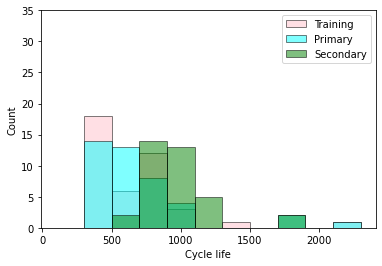

In [20]:
bins=np.arange(100,2500,200)# width 조절
Train_cycle=np.array(Train_cycle).ravel()
prim_test_cycle=np.array(prim_test_cycle).ravel()
Cycle3=np.array(Cycle3).ravel()
plt.hist(Train_cycle,bins,edgecolor='k',alpha=0.5,color='pink',label='Training')
plt.hist(prim_test_cycle,bins,edgecolor='k',alpha=0.5,color='aqua',label='Primary')
plt.hist(Cycle3,bins,edgecolor='k',alpha=0.5,color='green',label='Secondary')
plt.ylim(0,35)
plt.xlabel('Cycle life')
plt.ylabel('Count')
plt.legend()

In [21]:
import seaborn as sns
sns.__version__

'0.11.1'

[2160. 1434. 1074.  870.  788.  719.  857.  788.  559. 1017.  870.  860.
  709.  731.  742.  704.  617.  966.  702.  616.  300.  438.  444.  511.
  477.  483.  494.  461.  489.  527.  461.  468.  498.  492.  520.  463.
  478.  459.  429.  462.  487. 1852. 2237. 1709.  636. 1054.  880.  862.
  691.  534. 1014.  854.  842.  917.  876.  757.  703.  648.  625. 1051.
  651.  599.  335.  480.  561.  458.  485.  487.  502.  513.  495.  471.
  509.  481.  519.  499.  535.  465.  499.  466.  457.  429.  713. 1009.
 1063. 1115. 1048.  828.  667. 1836.  828. 1039. 1078.  817.  932.  816.
  858.  876. 1146. 1155.  813.  772. 1002.  825.  989. 1028.  850.  541.
  858.  935.  731. 1284. 1158. 1093.  923.  796.  786.  940. 1801.]


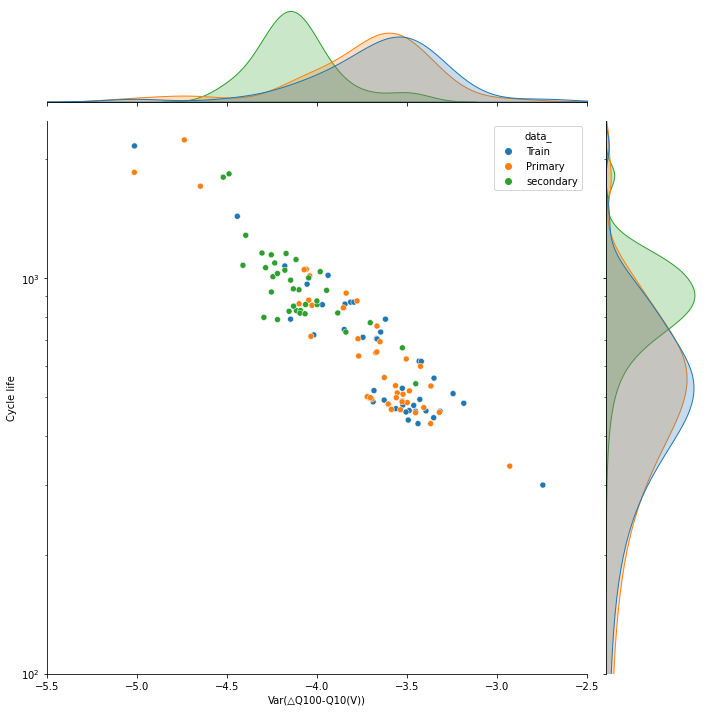

In [22]:
data1={'Var(△Q100-Q10(V))':X1,'Cycle life':Y1}
df1=pd.DataFrame(data1)
df1['data_']='Train'
data2={'Var(△Q100-Q10(V))':X2,'Cycle life':Y2}
df2=pd.DataFrame(data2)
df2['data_']='Primary'
data3={'Var(△Q100-Q10(V))':X3,'Cycle life':Y3}
df3=pd.DataFrame(data3)
df3['data_']='secondary'
df_sum=pd.concat([df1,df2,df3])
print(np.array(df_sum['Cycle life']))

sns.jointplot(x='Var(△Q100-Q10(V))',y='Cycle life',data=df_sum,xlim=(-5.5,-2.5),ylim=(100,2500),hue='data_',
              height=10)
plt.yscale('log')
plt.show()

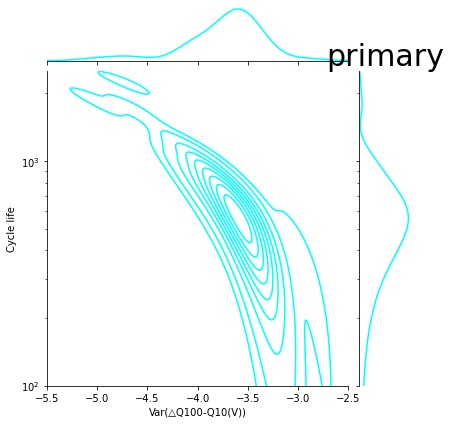

In [23]:
data2={'Var(△Q100-Q10(V))':X2,'Cycle life':Y2}
df2=pd.DataFrame(data2)

sns.jointplot(x='Var(△Q100-Q10(V))',y='Cycle life',data=df2,xlim=(-5.5,-2.5),ylim=(100,2500),color='aqua',kind="kde")
plt.yscale('log')
plt.title('primary',size=30)
plt.show()

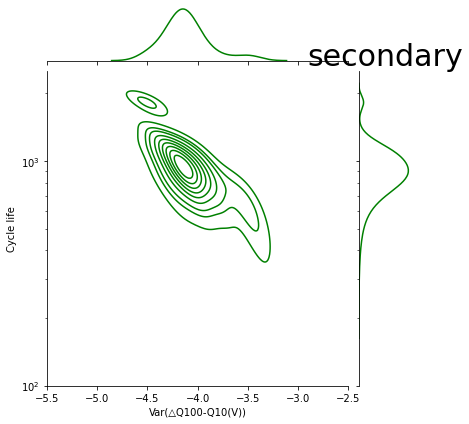

In [24]:
data3={'Var(△Q100-Q10(V))':X3,'Cycle life':Y3}
df3=pd.DataFrame(data3)

sns.jointplot(x='Var(△Q100-Q10(V))',y='Cycle life',data=df3,xlim=(-5.5,-2.5),ylim=(100,2500),color='green',kind="kde")
plt.yscale('log')
plt.title('secondary',size=30)
plt.show()

In [70]:
print('secondary RMSE, Mean Absolute Percentage Error')
rmse3=np.sqrt(mean_squared_error(10**Y_val3,10**y_pred3))
rmse3,MAPE(10**Y_val3,10**y_pred3)

secondary RMSE, Mean Absolute Percentage Error


(159.54163797855193, 11.09295811634838)

C:\Users\JanggoonKim\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in power
  """


ValueError: x and y must be the same size

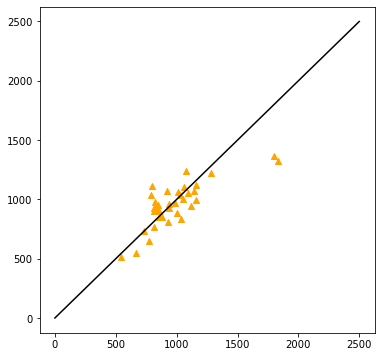

In [71]:
x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**Y_val3,10**y_pred3,color='orange',marker='^',label='secondary')
plt.scatter(10**Y2,10**Yt2,color='r',marker='s',label='primary test')
plt.scatter(10**Y_2,10**Yp2,color='r',marker='s',label='primary test')
plt.scatter(10**Y1,10**Yt1,color='b',marker='o',label='batch1')
plt.scatter(10**Y_1,10**Yp1,color='b',marker='o',label='batch1')
plt.axis([0,2500,0,2500])
plt.legend()

In [72]:
s_res=(10**y_pred3)-(10**Y_val3)
p_res=(10**y_pred2)-(10**p_Y_val)
print(p_res.shape,s_res.shape)

s_res=s_res.reshape(-1,1)
p_res=p_res.reshape(-1,1)
his=np.vstack([p_res,s_res])
print(his,his.shape)

(42,) (36,)
[[ 2.87950746e+02]
 [-5.75249760e+02]
 [-1.76914522e+02]
 [ 5.24447367e+01]
 [-1.57179662e+02]
 [ 6.01793766e+00]
 [ 6.80991082e+01]
 [-7.31134774e+01]
 [-5.63592345e+01]
 [-1.32226903e+02]
 [ 1.74763244e+01]
 [-9.82955866e+01]
 [-1.83661861e+02]
 [-1.81984230e+02]
 [-1.29491348e+02]
 [-1.22152814e+01]
 [-1.65486724e+01]
 [-8.37793631e+01]
 [-1.44222931e+02]
 [-2.30791337e+01]
 [-9.54410209e+01]
 [-1.43118587e+01]
 [ 1.11803210e+02]
 [ 4.36633089e+01]
 [-4.14815704e-01]
 [ 5.33798147e+01]
 [ 6.57312335e+01]
 [ 1.57049333e+02]
 [ 5.33245458e+01]
 [ 1.49142995e+02]
 [ 2.43168383e+01]
 [ 4.10336887e+01]
 [ 1.11935025e+02]
 [ 1.36856774e+01]
 [ 1.49635208e+02]
 [ 3.63506672e+01]
 [ 9.20680851e+01]
 [ 7.01749513e+01]
 [ 1.17565861e+02]
 [ 5.92233836e+01]
 [ 4.93829962e+01]
 [ 1.63282046e+02]
 [ 5.30002639e+01]
 [ 3.88073637e+01]
 [-1.70230162e+02]
 [-4.85102892e+01]
 [ 1.14893778e+02]
 [-1.15247162e+02]
 [-5.10346491e+02]
 [ 9.56789411e+01]
 [-2.02948140e+02]
 [ 1.57490434e+02]


(0.0, 25.0)

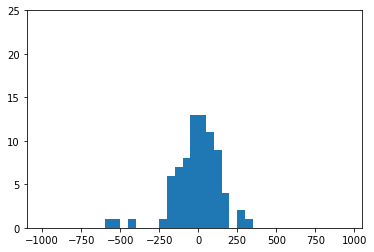

In [73]:
bins=np.arange(-1000,1000,50)# width 조절
plt.hist(his,bins)
plt.ylim(0,25)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,
         0.,  0.,  1.,  6.,  7.,  8., 13., 13., 11.,  9.,  4.,  0.,  2.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([-1000,  -950,  -900,  -850,  -800,  -750,  -700,  -650,  -600,
         -550,  -500,  -450,  -400,  -350,  -300,  -250,  -200,  -150,
         -100,   -50,     0,    50,   100,   150,   200,   250,   300,
          350,   400,   450,   500,   550,   600,   650,   700,   750,
          800,   850,   900,   950]),
 <BarContainer object of 39 artists>)

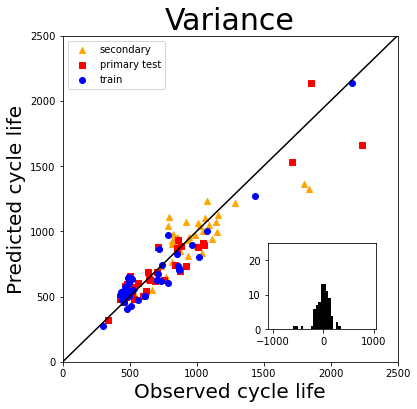

In [74]:
x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**Y_val3,10**y_pred3,color='orange',marker='^',label='secondary')
plt.scatter(10**p_Y_val,10**y_pred2,color='r',marker='s',label='primary test')
plt.scatter(10**Y_val,10**y_pred1,color='b',marker='o',label='train')
plt.axis([0,2500,0,2500])
plt.xlabel('Observed cycle life',size=20)
plt.ylabel('Predicted cycle life',size=20)
plt.title('Variance',size=30)
plt.legend()
ax_sub=plt.axes([0.6,0.2,0.25,0.2])
plt.ylim(0,25)
ax_sub.hist(his,bins,color='black')


C:\Users\JanggoonKim\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in power
  


ValueError: x and y must be the same size

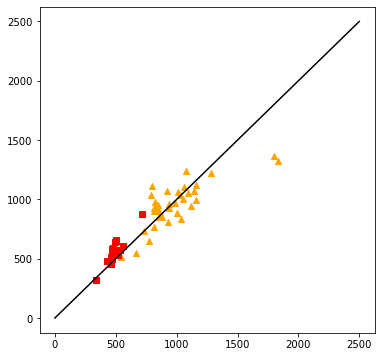

In [76]:
x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**Y_val3,10**y_pred3,color='orange',marker='^',label='batch3')
plt.scatter(10**Y2,10**Yt2,color='r',marker='s',label='batch2')
plt.scatter(10**Y_2,10**Yp2,color='r',marker='s')
plt.scatter(10**Y1,10**Yt1,color='b',marker='o')
plt.scatter(10**Y_1,10**Yp1,color='b',marker='o',label='batch1')
plt.axis([0,2500,0,2500])
plt.xlabel('Observed cycle life',size=20)
plt.ylabel('Predicted cycle life',size=20)
plt.title('Variance',size=30)
plt.legend()
ax_sub=plt.axes([0.6,0.2,0.25,0.2])
plt.ylim(0,25)
ax_sub.hist(his,bins,color='black')

In [31]:
# train
print(X.shape, Y_val.shape)

(41, 1) (41,)


In [32]:
X_pd=X.ravel()
dict_data={'Train_var':X_pd,'Train_label':Y_val}
df=pd.DataFrame(dict_data)
print(df)

    Train_var  Train_label
0   -5.013960     3.334454
1   -4.442613     3.156549
2   -4.178878     3.031004
3   -3.813486     2.939519
4   -4.146897     2.896526
5   -4.017949     2.856729
6   -3.970159     2.932981
7   -3.619907     2.896526
8   -3.350338     2.747412
9   -3.938663     3.007321
10  -3.795220     2.939519
11  -3.844712     2.934498
12  -3.744699     2.850646
13  -3.646463     2.863917
14  -3.848616     2.870404
15  -3.669501     2.847573
16  -3.433048     2.790285
17  -4.055213     2.984977
18  -3.665856     2.846337
19  -3.420700     2.789581
20  -2.745713     2.477121
21  -3.493259     2.641474
22  -3.352005     2.647383
23  -3.244390     2.708421
24  -3.462718     2.678518
25  -3.184818     2.683947
26  -3.428992     2.693727
27  -3.316005     2.663701
28  -3.526536     2.689309
29  -3.526259     2.721811
30  -3.452463     2.663701
31  -3.561808     2.670246
32  -3.708903     2.697229
33  -3.627064     2.691965
34  -3.683620     2.716003
35  -3.488171     2.665581
3

In [33]:
dict_data1={'Primary_var':p_X_val,'Primary_label':p_Y_val}
df1=pd.DataFrame(dict_data1)
print(df1)

    Primary_var  Primary_label
0     -5.014861       3.267641
1     -4.737000       3.349666
2     -4.647744       3.232742
3     -3.768878       2.803457
4     -4.059384       3.022841
5     -4.046070       2.944483
6     -4.099414       2.935507
7     -3.650081       2.839478
8     -3.367237       2.727541
9     -4.040794       3.006038
10    -4.027889       2.931458
11    -3.853703       2.925312
12    -3.838282       2.962369
13    -3.777733       2.942504
14    -3.667058       2.879096
15    -3.772606       2.846955
16    -3.673939       2.811575
17    -3.504534       2.795880
18    -4.071514       3.021603
19    -3.667779       2.813581
20    -3.425292       2.777427
21    -2.929546       2.525045
22    -3.602695       2.681241
23    -3.626313       2.748963
24    -3.320110       2.660865
25    -3.498752       2.685742
26    -3.527655       2.687529
27    -3.720936       2.700704
28    -3.554347       2.710117
29    -3.695802       2.694605
30    -3.407161       2.673021
31    -3

In [34]:
dict_data2={'Train_var':X_val3,'Train_label':Y_val3}
df2=pd.DataFrame(dict_data2)
print(df2)

    Train_var  Train_label
0   -4.245115     3.003891
1   -4.285543     3.026533
2   -4.116608     3.047275
3   -4.178466     3.020361
4   -4.114424     2.918030
5   -3.525708     2.824126
6   -4.488742     3.263873
7   -4.091804     2.918030
8   -3.982297     3.016616
9   -4.411356     3.032619
10  -3.884921     2.912222
11  -3.946790     2.969416
12  -4.094466     2.911690
13  -3.999668     2.933487
14  -4.000684     2.942504
15  -4.254052     3.059185
16  -4.171942     3.062582
17  -4.066345     2.910091
18  -3.704327     2.887617
19  -4.046822     3.000868
20  -4.155255     2.916454
21  -4.146561     2.995196
22  -4.219507     3.011993
23  -4.130132     2.929419
24  -3.451658     2.733197
25  -4.063576     2.933487
26  -4.100226     2.970812
27  -3.839603     2.863917
28  -4.395898     3.108565
29  -4.305660     3.063709
30  -4.234858     3.038620
31  -4.253458     2.965202
32  -4.295108     2.900913
33  -4.219509     2.895423
34  -4.131496     2.973128
35  -4.520851     3.255514


In [35]:
MAPE3=MAPE(10**Y_val3,10**y_pred3)
MAPE2=MAPE(10**p_Y_val,10**y_pred2)
MAPE1=MAPE(10**Y_val,10**y_pred1)

In [36]:
print('             RMSE(cycles)')
print('Train        Primary test       Secondary test')
print(round(rmse1,1),'          ',round(rmse2,1),'             ',round(rmse3,1))

             RMSE(cycles)
Train        Primary test       Secondary test
103.6            138.4               159.5


In [37]:
print('         Mean percent error(%)')
print('Train        Primary test       Secondary test')
print(round(MAPE1,1),'          ',round(MAPE2,1),'               ',round(MAPE3,1))

         Mean percent error(%)
Train        Primary test       Secondary test
14.1            13.2                 11.1


In [38]:
X_val.shape, Y_val.shape

((41,), (41,))

C:\Users\JanggoonKim\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09741112439047189, tolerance: 0.00010703521221153374
  positive)


<function matplotlib.pyplot.show(close=None, block=None)>

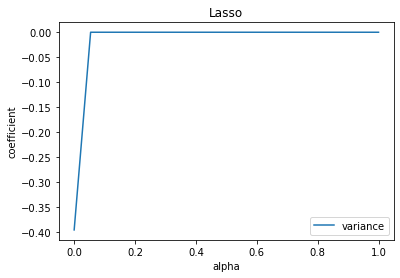

In [39]:
X_=X_val.reshape(-1,1)
Y_lasso=[]
X_lasso=[]
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
for i in np.linspace(0,1,1000):
    regrplot=Lasso(alpha=i)
    regrplot.fit(X_,Y_val)
    Y_lasso.append(regrplot.coef_)
    X_lasso.append(i)
Y_=np.array(Y_lasso)    

plt.plot(X_lasso,Y_,label='variance')

plt.title('Lasso')
plt.xlabel('alpha')
plt.ylabel('coefficient')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

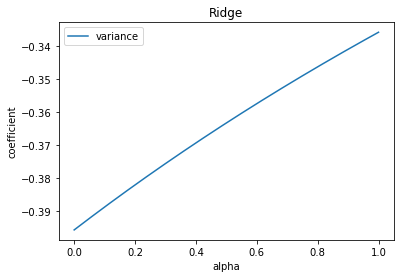

In [40]:
Y_Ridge=[]
X_Ridge=[]
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
for i in np.linspace(0,1,1000):
    regrplot=Ridge(alpha=i)
    regrplot.fit(X_,Y_val)
    Y_Ridge.append(regrplot.coef_)
    X_Ridge.append(i)
Y_=np.array(Y_Ridge)    

plt.plot(X_Ridge,Y_,label='variance')

plt.title('Ridge')
plt.xlabel('alpha')
plt.ylabel('coefficient')
plt.legend()
plt.show

C:\Users\JanggoonKim\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09741112439047189, tolerance: 0.00010703521221153374
  positive)


<function matplotlib.pyplot.show(close=None, block=None)>

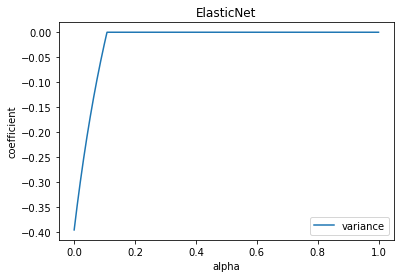

In [41]:
from sklearn.linear_model import ElasticNet
Y_ElasticNet=[]
X_ElasticNet=[]
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
for i in np.linspace(0,1,1000):
    regrplot=ElasticNet(alpha=i)
    regrplot.fit(X_,Y_val)
    Y_ElasticNet.append(regrplot.coef_)
    X_ElasticNet.append(i)
Y_=np.array(Y_ElasticNet)    

plt.plot(X_ElasticNet,Y_,label='variance')

plt.title('ElasticNet')
plt.xlabel('alpha')
plt.ylabel('coefficient')
plt.legend()
plt.show

In [42]:
from sklearn.linear_model import LassoCV
reg = LassoCV(cv=4).fit(X_,Y_val)
print('Lasso CV alpha:',reg.alpha_)
print('Lasso CV coefficient:',reg.coef_)
print('Lasso CV intercept:',reg.intercept_)

Lasso CV alpha: 5.394560378807524e-05
Lasso CV coefficient: [-0.39545452]
Lasso CV intercept: 1.3474666664691395


In [43]:
Lassocv=reg.predict(X_)
rmseLassocv=np.sqrt(mean_squared_error(10**Y_val,10**Lassocv))
print('RMSE','           ','MAPE')
print(rmseLassocv,MAPE(10**Y_val,10**Lassocv))

RMSE             MAPE
103.62259283366636 14.131259187096731


In [44]:
Lassocv2=reg.predict(p_X)
rmseLassocv2=np.sqrt(mean_squared_error(10**p_Y_val,10**Lassocv2))
print('RMSE','           ','MAPE')
print(rmseLassocv2,MAPE(10**p_Y_val,10**Lassocv2))

RMSE             MAPE
138.3896879707659 13.194712835250263


In [45]:
Lassocv3=reg.predict(X3)
rmseLassocv3=np.sqrt(mean_squared_error(10**Y_val3,10**Lassocv3))
print('RMSE','           ','MAPE')
print(rmseLassocv3,MAPE(10**Y_val3,10**Lassocv3))

ValueError: Expected 2D array, got 1D array instead:
array=[-4.24511487 -4.28554271 -4.11660777 -4.17846567 -4.11442397 -3.52570819
 -4.48874219 -4.09180376 -3.98229695 -4.41135592 -3.88492116 -3.94678998
 -4.09446649 -3.99966769 -4.00068442 -4.254052   -4.17194187 -4.06634469
 -3.70432669 -4.0468224  -4.15525499 -4.14656074 -4.21950741 -4.13013231
 -3.45165789 -4.0635761  -4.10022555 -3.83960303 -4.39589833 -4.3056595
 -4.23485829 -4.25345792 -4.29510827 -4.21950937 -4.13149552 -4.5208508 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [46]:
from sklearn.linear_model import RidgeCV
reg = RidgeCV(cv=4).fit(X_,Y_val)
print('Ridge CV alpha:',reg.alpha_)
print('Ridge CV coefficient:',reg.coef_)
print('Ridge CV intercept:',reg.intercept_)

Ridge CV alpha: 0.1
Ridge CV coefficient: [-0.38889023]
Ridge CV intercept: 1.3714776972084437


In [47]:
Ridgecv=reg.predict(X_)
rmseRidgecv=np.sqrt(mean_squared_error(10**Y_val,10**Ridgecv))
print('RMSE','           ','MAPE')
print(rmseRidgecv,MAPE(10**Y_val,10**Ridgecv))

RMSE             MAPE
104.74933977386164 14.243291552586687


In [48]:
Ridgecv2=reg.predict(p_X)
rmseRidgecv2=np.sqrt(mean_squared_error(10**p_Y_val,10**Ridgecv2))
print('RMSE','           ','MAPE')
print(rmseRidgecv2,MAPE(10**p_Y_val,10**Ridgecv2))

RMSE             MAPE
140.19741635636422 13.223322458461556


In [49]:
Ridgecv3=reg.predict(X3)
rmseRidgecv3=np.sqrt(mean_squared_error(10**Y_val3,10**Ridgecv3))
print('RMSE','           ','MAPE')
print(rmseRidgecv3,MAPE(10**Y_val3,10**Ridgecv3))

ValueError: Expected 2D array, got 1D array instead:
array=[-4.24511487 -4.28554271 -4.11660777 -4.17846567 -4.11442397 -3.52570819
 -4.48874219 -4.09180376 -3.98229695 -4.41135592 -3.88492116 -3.94678998
 -4.09446649 -3.99966769 -4.00068442 -4.254052   -4.17194187 -4.06634469
 -3.70432669 -4.0468224  -4.15525499 -4.14656074 -4.21950741 -4.13013231
 -3.45165789 -4.0635761  -4.10022555 -3.83960303 -4.39589833 -4.3056595
 -4.23485829 -4.25345792 -4.29510827 -4.21950937 -4.13149552 -4.5208508 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [50]:
#2 Lasso 
s_res=(10**Lassocv3)-(10**Y_val3)
p_res=(10**Lassocv2)-(10**p_Y_val)

s_res=s_res.reshape(-1,1)
p_res=p_res.reshape(-1,1)
his=np.vstack([p_res,s_res])

bins=np.arange(-1000,1000,50)# width 조절
plt.hist(his,bins)
plt.ylim(0,25)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**Y_val3,10**Lassocv3,color='orange',marker='^',label='secondary')
plt.scatter(10**p_Y_val,10**Lassocv2,color='r',marker='s',label='primary test')
plt.scatter(10**Y_val,10**Lassocv,color='b',marker='o',label='train')
plt.axis([0,2500,0,2500])
plt.xlabel('Observed cycle life',size=20)
plt.ylabel('Predicted cycle life',size=20)
plt.title('Variance(Lasso)',size=30)
plt.legend()
ax_sub=plt.axes([0.6,0.2,0.25,0.2])
plt.ylim(0,25)
ax_sub.hist(his,bins,color='black')

NameError: name 'Lassocv3' is not defined

In [51]:
#3 Ridge 
s_res=(10**Ridgecv3)-(10**Y_val3)
p_res=(10**Ridgecv2)-(10**p_Y_val)

s_res=s_res.reshape(-1,1)
p_res=p_res.reshape(-1,1)
his=np.vstack([p_res,s_res])

bins=np.arange(-1000,1000,50)# width 조절
plt.hist(his,bins)
plt.ylim(0,25)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**Y_val3,10**Ridgecv3,color='orange',marker='^',label='secondary')
plt.scatter(10**p_Y_val,10**Ridgecv2,color='r',marker='s',label='primary test')
plt.scatter(10**Y_val,10**Ridgecv,color='b',marker='o',label='train')
plt.axis([0,2500,0,2500])
plt.xlabel('Observed cycle life',size=20)
plt.ylabel('Predicted cycle life',size=20)
plt.title('Variance(Ridge)',size=30)
plt.legend()
ax_sub=plt.axes([0.6,0.2,0.25,0.2])
plt.ylim(0,25)
ax_sub.hist(his,bins,color='black')

NameError: name 'Ridgecv3' is not defined